In [5]:
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, select, Float, DateTime, or_
from sqlalchemy.orm import Session
from sqlalchemy.sql import func
from urllib.parse import quote_plus
from collections import defaultdict
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

class CryptoAnalyzer:
    def __init__(self, username, password, server, database):
        try:
            self.engine = create_engine(f'mysql+pymysql://{quote_plus(username)}:{quote_plus(password)}@{server}:3306/{database}', echo=False)
            self.conn = self.engine.connect()
            self.meta = MetaData()
            self.meta.reflect(bind=self.engine)
            self.session = Session(self.engine)
        except Exception as e:
            print(f"Error: {e}")

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.session.close()
        self.conn.close()

    def get_random_crypto_ids(self):
        try:
            random_crypto_ids = self.session.query(self.meta.tables['cryptodailyhistory'].c.crypto_id) \
                .distinct() \
                .order_by(func.random()) \
                .limit(40) \
                .all()
            return [result[0] for result in random_crypto_ids]
        except Exception as e:
            print(f"Error: {e}")

    def get_avg_volumes(self, random_crypto_ids):
        try:
            crypto_data_with_avg_volume = []

            for crypto_id in random_crypto_ids:
                crypto_data = self.session.query(self.meta.tables['cryptodailyhistory'].c.volume) \
                    .filter(self.meta.tables['cryptodailyhistory'].c.crypto_id == crypto_id) \
                    .all()
                
                volumes = [result[0] for result in crypto_data]
                avg_volume = sum(volumes) / len(volumes)
                crypto_data_with_avg_volume.append((crypto_id, avg_volume))
            
            avg_volumes = [float(data[1]) for data in crypto_data_with_avg_volume]
            mean_avg_volumes = np.mean(avg_volumes)
            t_multiplier = stats.t.ppf((1 + 0.98) / 2, df=40-1)
            margin_of_error = t_multiplier * (mean_avg_volumes / np.sqrt(40))
            lower_bound = mean_avg_volumes - margin_of_error
            upper_bound = mean_avg_volumes + margin_of_error

            return lower_bound, upper_bound
        except Exception as e:
            print(f"Error: {e}")

    def get_max_price_diff(self):
        try:
            res1 = self.session.query(
                self.meta.tables['cryptohistoricalprices'].c.crypto_price,
                self.meta.tables['cryptopricetimes'].c.crypto_daily_id,
                self.meta.tables['cryptopricetimes'].c.crypto_price_type_id,
                self.meta.tables['dates'].c.date,
                self.meta.tables['cryptocurrencies'].c.crypto_name,
                self.meta.tables['cryptodailyhistory'].c.volume
            ).filter(
                self.meta.tables['cryptohistoricalprices'].c.crypto_price_time_id == self.meta.tables['cryptopricetimes'].c.crypto_price_time_id
            ).filter(
                self.meta.tables['cryptopricetimes'].c.crypto_daily_id == self.meta.tables['cryptodailyhistory'].c.crypto_daily_id,
                self.meta.tables['cryptodailyhistory'].c.crypto_id == self.meta.tables['cryptocurrencies'].c.crypto_id,
                self.meta.tables['dates'].c.date_id == self.meta.tables['cryptodailyhistory'].c.date_id
            ).filter(
                or_(
                    self.meta.tables['cryptopricetimes'].c.crypto_price_type_id == 1,
                    self.meta.tables['cryptopricetimes'].c.crypto_price_type_id == 2
                )
            ).all()

            data_dict = defaultdict(lambda: {'price_type_1': None, 'price_type_2': None, 'volume': None, 'crypto_name': None})

            for row in res1:
                crypto_price, daily_id, price_type_id, date, crypto_name, volume = row
                if price_type_id == 1:
                    data_dict[daily_id]['price_type_1'] = crypto_price
                elif price_type_id == 2:
                    data_dict[daily_id]['price_type_2'] = crypto_price
                data_dict[daily_id]['volume'] = volume
                data_dict[daily_id]['crypto_name'] = crypto_name

            data_dict = {k: v for k, v in data_dict.items() if v.get('price_type_1') is not None and v.get('price_type_2') is not None}

            for daily_id, data in data_dict.items():
                data['price_difference'] = data['price_type_2'] - data['price_type_1']

            return data_dict
        except Exception as e:
            print(f"Error: {e}")

    def get_top_10_max_price_diff(self, data_dict):
        try:
            entries = list(data_dict.values())
            sorted_entries = sorted(entries, key=lambda x: x['price_difference'], reverse=True)
            max_price_diff_dict = {}

            for entry in sorted_entries:
                crypto_name = entry["crypto_name"]
                price_diff = entry["price_difference"]
                volume = entry["volume"]
                if crypto_name not in max_price_diff_dict or price_diff > max_price_diff_dict[crypto_name]["price_difference"]:
                    max_price_diff_dict[crypto_name] = entry

            top_10_max_price_diff = sorted(max_price_diff_dict.values(), key=lambda x: x["price_difference"], reverse=True)[:10]

            for entry in top_10_max_price_diff:
                entry["volume"] = max_price_diff_dict[entry["crypto_name"]]["volume"]

            return top_10_max_price_diff
        except Exception as e:
            print(f"Error: {e}")

    def plot_volume_by_crypto_name(self,results_array):
        try:
            crypto_names = [entry['crypto_name'] for entry in results_array]
            volumes = [float(entry['volume']) for entry in results_array]

            fig, ax = plt.subplots(figsize=(16, 9))

            ax.barh(crypto_names, volumes, color='#164B60')

            for i, v in enumerate(volumes):
                ax.text(v + 3, i, f'{v:.2f}', color='black', va='center')

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.invert_yaxis()

            plt.xlabel('Volume')
            plt.ylabel('Crypto Name')
            plt.title('Volume of Crypto Name')
            plt.xscale('log')
            plt.show()
        except Exception as e:
            print(f"Error: {e}")

    def get_price_difference_by_day(self):
        try:
            res2 = self.session.query(
                self.meta.tables['cryptohistoricalprices'].c.crypto_price,
                self.meta.tables['cryptopricetimes'].c.crypto_daily_id,
                self.meta.tables['cryptopricetimes'].c.crypto_price_type_id,
                self.meta.tables['dates'].c.date,
                self.meta.tables['dates'].c.date_id,
            ).filter(
                self.meta.tables['cryptohistoricalprices'].c.crypto_price_time_id == self.meta.tables['cryptopricetimes'].c.crypto_price_time_id
            ).filter(
                self.meta.tables['cryptopricetimes'].c.crypto_daily_id == self.meta.tables['cryptodailyhistory'].c.crypto_daily_id,
                self.meta.tables['cryptodailyhistory'].c.crypto_id == self.meta.tables['cryptocurrencies'].c.crypto_id,
                self.meta.tables['dates'].c.date_id == self.meta.tables['cryptodailyhistory'].c.date_id
            ).filter(
                or_(
                    self.meta.tables['cryptopricetimes'].c.crypto_price_type_id == 1,
                    self.meta.tables['cryptopricetimes'].c.crypto_price_type_id == 2
                )
            ).all()

            day_names_dict = {}

            for result in res2:
                day_of_week = result[3].weekday()
                days_of_week_names = ["Monday", "Tuesday", "Wednesday",'Thursday','Friday','Saturday', "Sunday"]
                day_name = days_of_week_names[day_of_week]
                day_names_dict[result[4]] = day_name

            res2 = [(result[0], result[1], result[2], result[3], result[4], day_names_dict[result[4]]) for result in res2]
            data_dict = {}

            for row in res2:
                crypto_price, daily_id, price_type_id, date, date_id, day_name = row
                if daily_id not in data_dict:
                    data_dict[daily_id] = {'price_type_1': None, 'price_type_2': None, 'day_name': day_name}
                if price_type_id == 1:
                    data_dict[daily_id]['price_type_1'] = crypto_price
                elif price_type_id == 2:
                    data_dict[daily_id]['price_type_2'] = crypto_price

            for daily_id, data in data_dict.items():
                price_type_1 = data['price_type_1']
                price_type_2 = data['price_type_2']
                if price_type_1 is not None and price_type_2 is not None:
                    price_difference = price_type_2 - price_type_1
                    data['price_difference'] = price_difference

            data_dict = {k: v for k, v in data_dict.items()}

            price_diffs_weekdays = [data['price_difference'] for data in data_dict.values() if data.get('day_name') in ['Tuesday', 'Monday', 'Sunday'] and 'price_difference' in data]
            average_price_diff_weekdays = sum(price_diffs_weekdays) / len(price_diffs_weekdays) if price_diffs_weekdays else None


            price_diffs_weekends = [data['price_difference'] for data in data_dict.values() if data.get('day_name') in ['Thursday','Friday','Saturday'] and 'price_difference' in data]
            average_price_diff_weekends = sum(price_diffs_weekends) / len(price_diffs_weekends) if price_diffs_weekends else None

            return average_price_diff_weekdays,average_price_diff_weekends
        except Exception as e:
            print(f"Error: {e}")
            return e

# Usage
username = 'qazal'
password = '6857'
server = 'localhost'
database = 'crypto'

Q5:

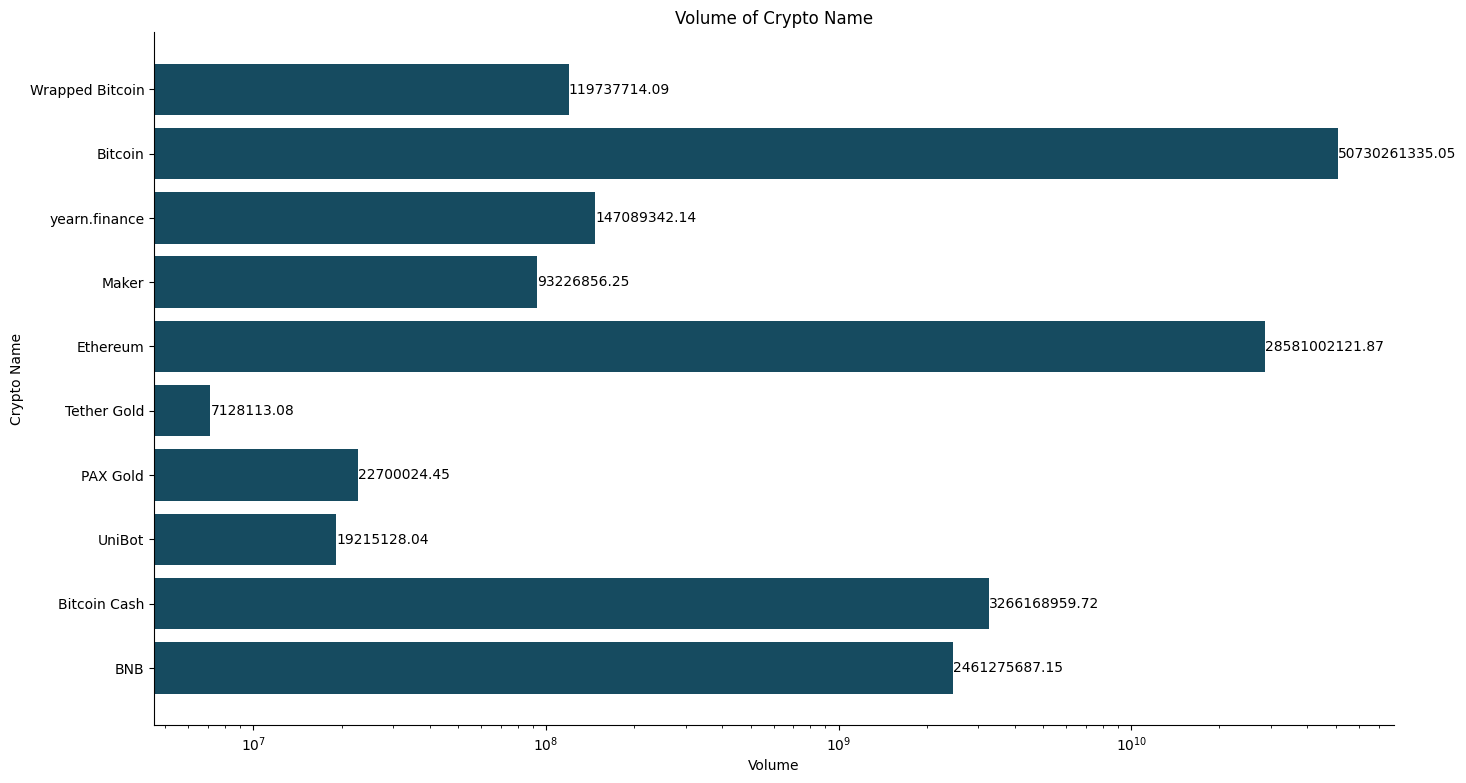

In [6]:
with CryptoAnalyzer(username, password, server, database) as crypto_analyzer:
    data_dict = crypto_analyzer.get_max_price_diff()
    top_10_max_price_diff = crypto_analyzer.get_top_10_max_price_diff(data_dict)
    crypto_analyzer.plot_volume_by_crypto_name(top_10_max_price_diff)

Estimate

In [7]:
with CryptoAnalyzer(username, password, server, database) as crypto_analyzer:
    random_crypto_ids = crypto_analyzer.get_random_crypto_ids()
    lower_bound, upper_bound = crypto_analyzer.get_avg_volumes(random_crypto_ids)
print(f'98% confidence interval:{lower_bound, upper_bound}')

98% confidence interval:(551850344.0636598, 1238590354.8997307)


hypothesis test
Q1:

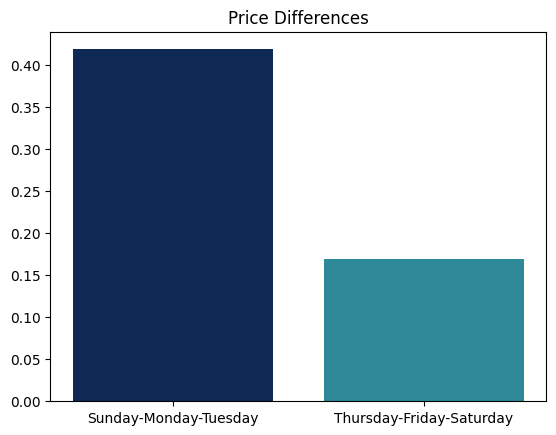

In [8]:
with CryptoAnalyzer(username, password, server, database) as crypto_analyzer:
    average_price_diff_weekdays,average_price_diff_weekends=crypto_analyzer.get_price_difference_by_day()
def draw_bar_chart(average_price_diff_weekdays, average_price_diff_weekends):
    labels = ['Sunday-Monday-Tuesday','Thursday-Friday-Saturday']
    values = [average_price_diff_weekdays, average_price_diff_weekends]
    colors = ['#0E2954','#2E8A99']
    
    fig, ax = plt.subplots()
    ax.bar(labels, values, color=colors)

    plt.title('Price Differences')
    plt.show()
draw_bar_chart(average_price_diff_weekdays, average_price_diff_weekends)


<div style="direction: rtl; text-align: right;">
  
  بله تفاوت فاحشی میان دو انتخاب ممکن برای روزهای کاری وجود دارد.
  
  با توجه به میانگین تغییر قیمت رمزارزها در دو گروه زمانی مورد بحث، انتخاب روزهای چهارشنبه تا شنبه به عنوان روزهای کاری به نظر می‌رسد مناسب باشد.
    
  
   - میانگین تغییر قیمت در روزهای "یکشنبه، دوشنبه، سه‌شنبه" بیشتر است که نشان دهنده فعالیت بیشتر در این روزها در بازار رمزارزها می‌باشد. 
   انتخاب روزهای "پنجشنبه، جمعه، شنبه" به عنوان روزهای آخر هفته، معمولاً باعث می‌شود که فعالیت بازار کمتر باشد و تغییرات قیمت نیز کاهش یابد.

<div/>